In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [40]:
file_path = '波士顿房价.csv'
df = pd.read_csv(file_path, header=0)
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [41]:
# 随机选取一个特征用于画图与训练模型
# 'MEDV'为房屋价格
label = list(df.columns)
label = [i for i in label if i != 'MEDV' ]
select_label = ['NOX']
select_label.append('MEDV')
data = df[select_label]
data

,NOX,MEDV
0,0.538,24.0
1,0.469,21.6
2,0.469,34.7
3,0.458,33.4
4,0.458,36.2
...,...,...
501,0.573,22.4
502,0.573,20.6
503,0.573,23.9
504,0.573,22.0


<Axes: xlabel='NOX', ylabel='MEDV'>

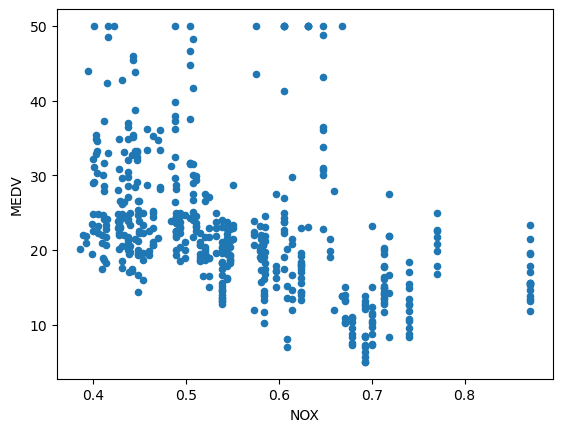

In [42]:
# 数据集的散点图
data.plot(kind='scatter',x=select_label[0],y='MEDV')

In [43]:
# 提取出数据和标签
x_data = data.drop(columns='MEDV')
y_data = data['MEDV']

In [44]:
# 将DataFrame转换为PyTorch张量
X = torch.tensor(x_data.values, dtype=torch.float32)
y = torch.tensor(y_data.values, dtype=torch.float32).reshape(-1, 1)

In [45]:
# 数据加载器
def data_iter(batch_size, data, labels):
    num_examples = len(data)
    indices = list(range(num_examples))
    # 随机读取样本
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        # yield是一个生成器，每次迭代时只计算当前值
        yield data[batch_indices], labels[batch_indices]

In [46]:
# 定义线性回归模型
def linear(X, a, b):
    return torch.matmul(X, a) + b
# 定义损失函数
def loss(y,y_hat):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2
# 梯度下降
def sgd(params,lr,batch_size):
    """
    params:模型参数
    lr:学习率
    batch_size:每次读取的数据量的数量
    """
    with torch.no_grad():   # 不对梯度进行追踪，保证后续参数的更新不被影响
        for param in params:
            param -= lr*param.grad / batch_size
            param.grad.zero_()   # 清空梯度
def backwards(X,y,y_hat,a,b):
    """
    X:输入的数据
    y:真实值
    y_hat:预测值
    a:模型参数
    b:偏置值
    """
    y_hat_grad = y_hat-y
    a_grad = torch.matmul(X.T,y_hat_grad)
    b_grad = y_hat_grad.sum(dim=0)
    a.grad = a_grad
    b.grad = b_grad

In [47]:
model = linear  # 模型
lr = 0.03   # 学习率
num_epochs = 500    # 训练次数
batch_size = 10 # 一次读取的数据量

In [48]:
# 初始化模型参数
# 模型为 y = ax + b
a = torch.normal(0, 0.01, size=(len(select_label)-1,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [49]:
for epoch in range(num_epochs): #训练模型
    for X_train,y_train in data_iter(batch_size,X,y):
        y_hat = model(X_train,a,b)
        train_loss = loss(y_hat,y_train)
        backwards(X_train,y_train,y_hat,a,b)
        #backward(X,y,y_hat,a,b)
        sgd([a,b],lr,batch_size)
    with torch.no_grad():   # 模型评估
        train_l = loss(model(X,a,b), y)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 51.201481
epoch 2, loss 46.440235
epoch 3, loss 46.123863
epoch 4, loss 45.868862
epoch 5, loss 45.404438
epoch 6, loss 45.052006
epoch 7, loss 44.733032
epoch 8, loss 44.410954
epoch 9, loss 44.116776
epoch 10, loss 43.813953
epoch 11, loss 43.558022
epoch 12, loss 43.273674
epoch 13, loss 42.984165
epoch 14, loss 42.744869
epoch 15, loss 42.473907
epoch 16, loss 42.230919
epoch 17, loss 42.106098
epoch 18, loss 41.800907
epoch 19, loss 41.587002
epoch 20, loss 41.332703
epoch 21, loss 41.142292
epoch 22, loss 40.923290
epoch 23, loss 40.721077
epoch 24, loss 40.532097
epoch 25, loss 40.389297
epoch 26, loss 40.168682
epoch 27, loss 39.993149
epoch 28, loss 39.825897
epoch 29, loss 39.662693
epoch 30, loss 39.518127
epoch 31, loss 39.352665
epoch 32, loss 39.273441
epoch 33, loss 39.068573
epoch 34, loss 38.922035
epoch 35, loss 38.813076
epoch 36, loss 38.673027
epoch 37, loss 38.537037
epoch 38, loss 38.410408
epoch 39, loss 38.285011
epoch 40, loss 38.191746
epoch 41,

In [50]:
# 最后一次训练得出的模型效果
for i in range(len(X)):
    y_hat = model(X[i],a,b)
    print(f'{y[i]}-{y_hat}')
print('test_loss:',loss(y,model(X,a,b)).mean())

tensor([24.])-tensor([22.8309], grad_fn=<AddBackward0>)
tensor([21.6000])-tensor([25.1791], grad_fn=<AddBackward0>)
tensor([34.7000])-tensor([25.1791], grad_fn=<AddBackward0>)
tensor([33.4000])-tensor([25.5534], grad_fn=<AddBackward0>)
tensor([36.2000])-tensor([25.5534], grad_fn=<AddBackward0>)
tensor([28.7000])-tensor([25.5534], grad_fn=<AddBackward0>)
tensor([22.9000])-tensor([23.3073], grad_fn=<AddBackward0>)
tensor([27.1000])-tensor([23.3073], grad_fn=<AddBackward0>)
tensor([16.5000])-tensor([23.3073], grad_fn=<AddBackward0>)
tensor([18.9000])-tensor([23.3073], grad_fn=<AddBackward0>)
tensor([15.])-tensor([23.3073], grad_fn=<AddBackward0>)
tensor([18.9000])-tensor([23.3073], grad_fn=<AddBackward0>)
tensor([21.7000])-tensor([23.3073], grad_fn=<AddBackward0>)
tensor([20.4000])-tensor([22.8309], grad_fn=<AddBackward0>)
tensor([18.2000])-tensor([22.8309], grad_fn=<AddBackward0>)
tensor([19.9000])-tensor([22.8309], grad_fn=<AddBackward0>)
tensor([23.1000])-tensor([22.8309], grad_fn=<Add

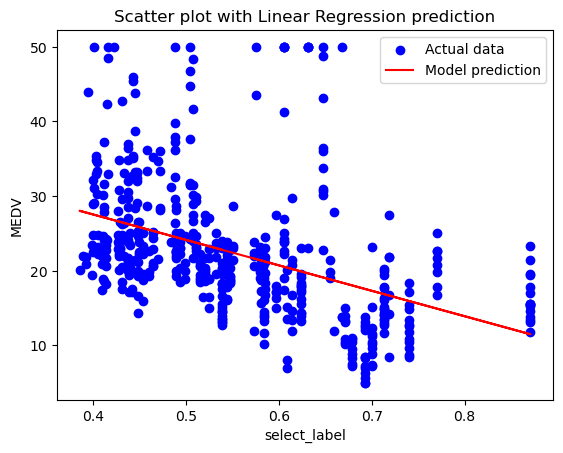

In [51]:
# 预测结果
y_pred = model(X,a,b).detach().numpy()
# 绘制散点图
plt.scatter(data[select_label[0]], data['MEDV'], color='blue', label='Actual data')
# 绘制模型的预测线
plt.plot(X, y_pred, color='red', label='Model prediction')
# 添加标题和图例
plt.title('Scatter plot with Linear Regression prediction')
plt.xlabel('select_label')
plt.ylabel('MEDV')
plt.legend()
# 显示图表
plt.show()

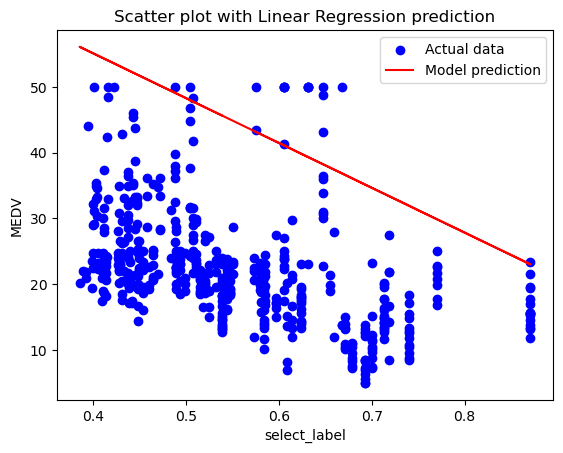

In [52]:
# 预测结果
y_pred1 = model(X,2*a,2*b).detach().numpy()
# 绘制散点图
plt.scatter(data[select_label[0]], data['MEDV'], color='blue', label='Actual data')
# 绘制模型的预测线
plt.plot(X, y_pred1, color='red', label='Model prediction')
# 添加标题和图例
plt.title('Scatter plot with Linear Regression prediction')
plt.xlabel('select_label')
plt.ylabel('MEDV')
plt.legend()
# 显示图表
plt.show()